In [1]:
from drivecycle import route, trajectory, utils, plots, graph, energy

import matplotlib.pyplot as plt
import networkx as nx

import psycopg

import requests
import polyline
import json
import pandas as pd
import numpy as np
import requests

import pickle
import glob
import os

import folium

import geopandas as gpd
import pandas as pd

In [2]:
# Valhalla API
valhalla_host = "http://localhost:8002"

In [3]:
# Connect to gtfs database
conn = psycopg.connect(
        host="localhost",
        dbname="postgis",
        user="username",
        password="password",
    )

###  Get Trip IDs for Route

In [4]:
# BC Transi1t Victoria Route 15
route_id="21"

cur = conn.execute(
    "SELECT DISTINCT ON (trips.shape_id) trips.shape_id,trips.trip_id, trips.direction_id, trips.trip_headsign FROM trips " 
    "JOIN routes ON trips.route_id=routes.route_id "
    "WHERE routes.route_short_name=%s", (route_id,)
    
)
shapes = cur.fetchall()
shapes

[('210021', '64329749', 1, 'CASTLERIDGE')]

### Get shapes for Trips

In [5]:
# Route 15 Eastbound = index 1
# Route 15 Westbound = index 4
route_index = 0

shape = shapes[route_index][0]

cur = conn.execute(
    "SELECT ST_AsGeoJSON(shapes_aggregated.shape) "
    "FROM shapes_aggregated " 
    "WHERE shapes_aggregated.shape_id=%s ", (shape,)
)

line = cur.fetchall()
geojson = json.loads(line[0][0])
coords = [tuple((i[1],i[0])) for i in geojson["coordinates"]]

### Valhalla Trace Attributes

In [6]:
b = polyline.encode(coords, 6)

trace_route = json.dumps({
    "encoded_polyline":b,
    "costing":"bus"
})

data =json.dumps({
    "encoded_polyline":b,
    "costing":"bus",
    "linear_references":True,
    "filters":{
        "attributes":[
            "shape",
            "edge.way_id",
            "edge.names",
            "edge.length",
            "edge.speed",
            "node.intersecting_edge.road_class",
            "node.elapsed_time",
            "node.type"
            ],
        "action":"include"
    }
})

height_data = json.dumps({"encoded_polyline":b,"range":True})

# Get Traces (intersections) and elevation from Valhalla
trace = requests.post(f"{valhalla_host}/trace_attributes", data=data)
height = requests.post(f"{valhalla_host}/height", data=height_data)


trace.json()["edges"]

[{'way_id': 196797541,
  'speed': 20,
  'length': 0.163,
  'source_percent_along': 0.192,
  'end_node': {'intersecting_edges': [{'road_class': 'service_other'},
    {'road_class': 'service_other'}],
   'elapsed_time': 29.376,
   'type': 'street_intersection'}},
 {'way_id': 196797539,
  'speed': 20,
  'length': 0.045,
  'end_node': {'intersecting_edges': [{'road_class': 'service_other'},
    {'road_class': 'service_other'}],
   'elapsed_time': 37.494,
   'type': 'street_intersection'}},
 {'way_id': 196797539,
  'speed': 20,
  'length': 0.009,
  'end_node': {'intersecting_edges': [{'road_class': 'tertiary'}],
   'elapsed_time': 39.123,
   'type': 'street_intersection'}},
 {'way_id': 574428626,
  'speed': 50,
  'length': 0.011,
  'names': ['Westwinds Drive NE'],
  'end_node': {'intersecting_edges': [{'road_class': 'service_other'}],
   'elapsed_time': 41.638,
   'type': 'street_intersection'}},
 {'way_id': 574428629,
  'speed': 50,
  'length': 0.074,
  'names': ['Westwinds Drive NE'],
  '

In [8]:
def intersection(x):
    results = []
    if "intersecting_edges" in x:
        for i in x["intersecting_edges"]:
            results.append(i["road_class"])
    return results
    
df = pd.DataFrame(trace.json()["edges"])
df["end"] = df["end_node"].map(intersection) 
df["lr"]=df["length"].cumsum()*1000
df["x"]=df["lr"]
df["y"]=0

gdf = gpd.GeoDataFrame(
    df[["way_id","end","speed"]], geometry=gpd.points_from_xy(df.x, df.y)
)
merged = gdf["geometry"].buffer(20).unary_union
node_clusters = gpd.GeoDataFrame(geometry=gpd.GeoSeries(merged.geoms))
centroids = node_clusters.centroid
node_clusters["x"] = centroids.x
node_clusters["y"] = centroids.y

gdf2 = gpd.sjoin(gdf, node_clusters, how="left", predicate="within")
gdf2 = gdf2.rename(columns={"index_right": "cluster"})

groups = gdf2.groupby("x")
for cluster_label, nodes_subset in groups:
    print(nodes_subset["end"])


0    [service_other, service_other]
Name: end, dtype: object
1    [service_other, service_other]
2                        [tertiary]
3                   [service_other]
Name: end, dtype: object
4    [service_other]
5    [service_other]
Name: end, dtype: object
6    [service_other]
Name: end, dtype: object
7    [service_other]
Name: end, dtype: object
8    [tertiary, service_other]
Name: end, dtype: object
9     [service_other, service_other]
10              [tertiary, tertiary]
11    [service_other, service_other]
Name: end, dtype: object
12    [residential]
Name: end, dtype: object
13                     [residential]
14    [service_other, service_other]
Name: end, dtype: object
15    [service_other, service_other]
Name: end, dtype: object
16     [unclassified]
17    [service_other]
Name: end, dtype: object
18                        [tertiary]
19    [service_other, service_other]
20                        [tertiary]
21                        [tertiary]
22                        [terti

In [30]:
# coords_trace = []

# for trace in route.json()["trip"]["legs"]:
#     coords_trace.append(polyline.decode(trace["shape"],6))

# coords_trace = polyline.decode(route.json()["trip"]["legs"][0]["shape"],6)
# m = folium.Map(location=[51.05084309996687, -114.07251113843348], zoom_start=12)

# folium.PolyLine(coords_trace, color="red", weight=5).add_to(m) #traced 
# folium.PolyLine(coords, color="blue", weight=5, opacity=0.2).add_to(m) #original
# m

In [283]:
# Tranformation of Trace attributes so we can input to Drivecycle

edges = trace.json()["edges"]

data_ = []

for edge in edges:
    length = edge["length"]*1000
    speed = edge["speed"]
    way_id = edge["way_id"]
    try:
        intersect = [edge["end_node"]["intersecting_edges"][0]["road_class"]]
    except:
        intersect = [None]

    item = {
        "way_id":way_id,
        "length":length,
        "speed":speed,
        "intersection":intersect,
    }
    data_.append(item)

## Validate Length

In [89]:
length = 0
for i in data_:
    length+=i["length"]
length

13048.0

In [90]:
cur = conn.execute("""
    SELECT ST_Length(
            ST_Transform(
                ST_SetSRID(shape_return.shape,4326),
                3402
            )
        ) as length
        FROM
    (
    SELECT stop_times.trip_id, trips.shape_id, stops.stop_loc, stop_times.stop_sequence, stop_times.stop_id FROM stop_times
    JOIN stops ON stop_times.stop_id=stops.stop_id
    JOIN trips ON stop_times.trip_id=trips.trip_id
    WHERE stop_times.trip_id=%s
    ORDER BY stop_times.stop_sequence
    ) AS stop_return
    JOIN (
    SELECT shapes_aggregated.shape, shapes_aggregated.shape_id
    FROM shapes_aggregated
    WHERE shapes_aggregated.shape_id=%s
    ) AS shape_return 
    ON stop_return.shape_id=shape_return.shape_id
    """,
    (shapes[route_index][1],shapes[route_index][0]))

result = cur.fetchall()
result[0][0]

14977.92681497533

### Get route stop locations & distances

In [91]:
trip_id = shapes[route_index][1]
cur = conn.execute(
    """
    SELECT ARRAY_AGG(b.shape_dist_traveled*1000)
    FROM (SELECT stop_times.stop_id, stop_times.stop_sequence, stop_times.shape_dist_traveled FROM stop_times
    WHERE stop_times.trip_id=%s
    ORDER BY stop_times.stop_sequence) as b
    JOIN stops ON b.stop_id=stops.stop_id
    """,
    (trip_id,))

stops = cur.fetchall()[0][0]
stops

[0.0, 7387.00008392334, 11923.00033569336, 14989.999771118164]

In [49]:
# cur = conn.execute("""
#     SELECT ST_LineLocatePoint(
#         ST_SetSRID(shape_return.shape,4326), 
#         stop_return.stop_loc::geometry) * 
#         ST_Length(
#             ST_Transform(
#                 ST_SetSRID(shape_return.shape,4326),
#                 3005
#             )
#         ) 
#         FROM
#     (
#     SELECT stop_times.trip_id, trips.shape_id, stops.stop_loc, stop_times.stop_sequence, stop_times.stop_id FROM stop_times
#     JOIN stops ON stop_times.stop_id=stops.stop_id
#     JOIN trips ON stop_times.trip_id=trips.trip_id
#     WHERE stop_times.trip_id=%s
#     ORDER BY stop_times.stop_sequence
#     ) AS stop_return
#     JOIN (
#     SELECT shapes_aggregated.shape, shapes_aggregated.shape_id
#     FROM shapes_aggregated
#     WHERE shapes_aggregated.shape_id=%s
#     ) AS shape_return 
#     ON stop_return.shape_id=shape_return.shape_id
#     """,
#     (shapes[route_index][1],shapes[route_index][0]))

# distances = cur.fetchall()
# stops = [round(i[0],2) for i in distances]
# stops

### Combine stop and intersection locations and consolidate graph

In [72]:
a = graph.Graph(data_)
a.include_stops(stops[1:])
a.consolidate_intersections()
a.simplify_graph()
len(a.get_edges())

99

### Get Drive Cycle

In [73]:
# Stop time durations
stop_params={"bus_stop":60,"tertiary":120, "secondary":60}

# Run for 5 iterations
iterations = 5
arr = np.zeros(iterations)

for i in range(iterations):
    dc = route.sequential(a.get_edges(),stops=stop_params, stop_at_node=True, step=1, a_max=1)
    elv = height.json()["range_height"]
    soc = energy.energy_model(dc, elv, m=14465, area=8.9, capacity=555)
    
    total_power = soc[-1,3]
    total_dist = soc[-1,2]
    
    # print(total_power, total_dist)
    
    arr[i]=(total_power/(total_dist/1000))
arr.mean()

INFO:root:Vi: 0.00. Reducing vf to 10.00 and v_target to 10.00 at time 76.0 and segment length 54.0
INFO:root:Could not complete segment: ti: 123.00, tf: 2.34,  vi: 11.11 , vf: 0.00,                                 v_target:24.72, length: 26.00
INFO:root:Vi: 0.00. Reducing vf to 20.00 and v_target to 22.25 at time 172.34 and segment length 231.0
INFO:root:Could not complete segment: ti: 282.34, tf: 9.90,  vi: 22.93 , vf: 0.00,                                 v_target:22.22, length: 227.00
INFO:root:Could not complete segment: ti: 521.24, tf: 4.23,  vi: 11.11 , vf: 0.00,                                 v_target:11.11, length: 47.00
INFO:root:Could not complete segment: ti: 1042.47, tf: 6.42,  vi: 16.67 , vf: 0.00,                                 v_target:16.67, length: 107.00
INFO:root:Vi: 9.72. Reducing vf to 10.00 and v_target to 12.50 at time 1367.8887261836487 and segment length 11.0
INFO:root:Could not complete segment: ti: 1368.89, tf: 3.87,  vi: 10.09 , vf: 0.00,                 

1.1655535405885495

In [74]:
print(f"Total Power: {arr.mean()}")

Total Power: 1.1655535405885495


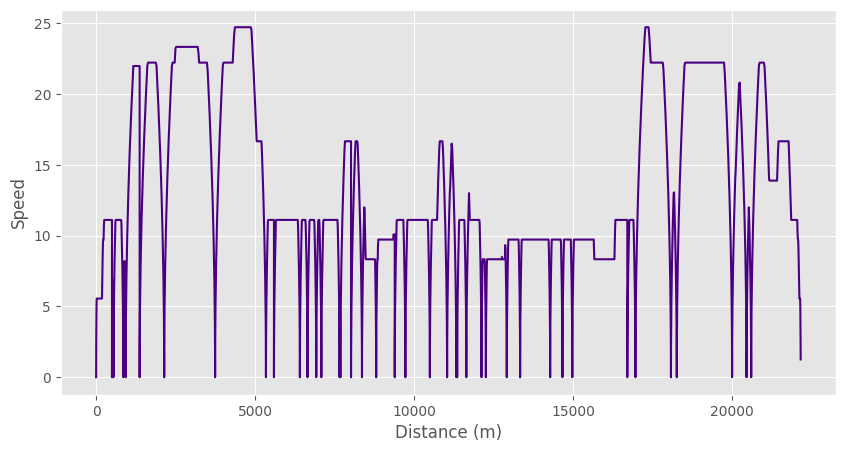

In [75]:
t=[i[2] for i in soc]
p=[i[1] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Speed")
plt.show()

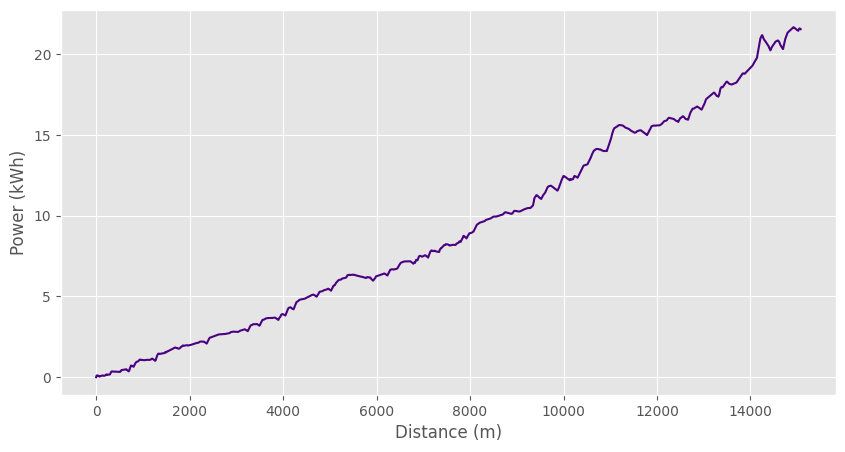

In [17]:
t=[i[2] for i in soc]
p=[i[3] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

## Validation with test data

In [287]:
time = pd.read_csv("./test_data/Route15/time.csv", header=0)
distance = pd.read_csv("./test_data/Route15/distance.csv", header=0)
speed = pd.read_csv("./test_data/Route15/speed.csv", header=0)

In [288]:
df = pd.concat((time, speed, distance), axis=1)
test_data = df[(distance.ne(distance.shift())).any(axis=1)] #remove duplicate consecutive distances
test_data = test_data.to_numpy()

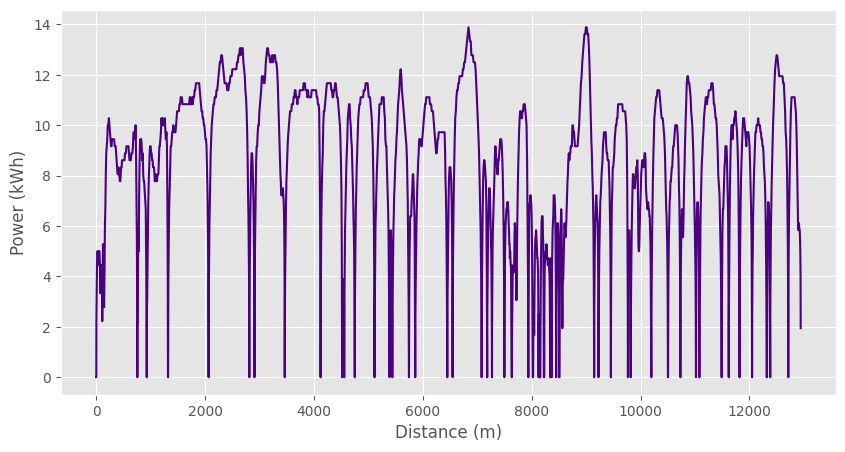

In [289]:
t=[i[2] for i in test_data]
p=[i[1] for i in test_data]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

In [271]:
soc = energy.energy_model(test_data, elv, m=14465, area=8.9, capacity=555)

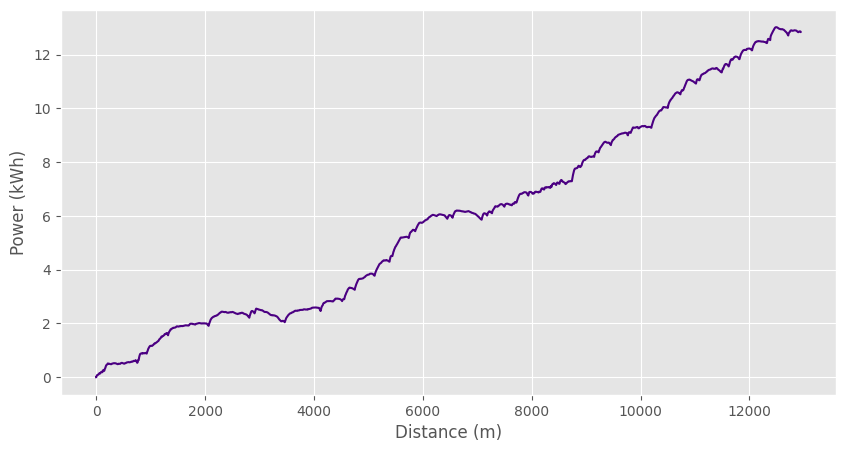

In [272]:
t=[i[2] for i in soc]
p=[i[3] for i in soc]

plt.figure(figsize=(10, 5))
plt.plot(t,p, color='#4b0082', linewidth=1.5)
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams.update({'font.size': 10})
plt.xlabel("Distance (m)")
plt.ylabel("Power (kWh)")
plt.show()

In [273]:
total_power = soc[-1,3]
total_dist = soc[-1,2]

print(total_power, total_dist)

(total_power/(total_dist/1000))

12.845625780522932 12940.964333


0.9926328092695572

## Summary

|Energy Consumption (kWh/km)       | Eastbound          | Westbound   |
| ------------- |:-------------:| ------:|
| Franca, A. (2015).      |  1.1  | 0.9 |
| Drivecycle Simulation     | 1.26      |   1.08 |
| Drivecycle using test data from Franca, A. (2015).  | -      |    0.99 |